In [ ]:
# 107303538_1118_hw10_2

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim # 最佳化資料庫

In [ ]:
# 數據
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # 攝氏溫度參數
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 未知參數(待得知關係的)
t_c = torch.tensor(t_c).unsqueeze(1) # 變成兩軸處理 直排 [ ,1]
t_u = torch.tensor(t_u).unsqueeze(1)
t_u.shape

torch.Size([11, 1])

小模型linear_model

In [ ]:
# 定義小model linear_model
linear_model = nn.Linear(1, 1) # 一個input和output 
# 想成nn.Linear為Linear regression model 為已經訓練好的model 內部包含多個功能(包含parameters與lr)

In [ ]:
# 小模型優化器
optimizer = optim.SGD( # SGD方法
  linear_model.parameters(), # 在linear_model裡面的parameters中已經有w和b
  lr=1e-2) # learning rate為1e-2

主模型seq_model(命名)

In [ ]:
# 自己添加的神經網路Hardtanh()
# 添加神經網路數量為15

In [ ]:
# 希望可以取有意義的名字
from collections import OrderedDict # 用dict的方式命名
seq_model = nn.Sequential(OrderedDict([ # OrderedDict
  ('hidden_linear', nn.Linear(1, 15)), # 把第一區線路取名為hidden_linear
  ('add_hidden_activation', nn.Hardtanh()), # 自己添加的神經網路Hardtanh()
  ('hidden_activation', nn.Tanh()), # 激活函數為hidden_activation
  ('output_linear', nn.Linear(15, 1)) # 輸出方的線路為output_linear
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=15, bias=True)
  (add_hidden_activation): Hardtanh(min_val=-1.0, max_val=1.0)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=15, out_features=1, bias=True)
)

分成train和validation的數據

In [ ]:
# 分成train和validation的數據
n_samples = t_u.shape[0] # 共幾筆資料
n_val = int(0.2 * n_samples) # n_val 設為驗證集 數量為sample的0.2倍
# int( )字符串或數字轉換為整數

In [ ]:
# 處理indice
shuffled_indices = torch.randperm(n_samples) # 把sample變成random 會有更好的學習效果
train_indices = shuffled_indices[:-n_val] # train的indice數 => 從前面取 取到倒數幾個(由驗證集的數量決定) 若驗證集為2則取道倒數-2個
val_indices = shuffled_indices[-n_val:] # val的indice數 => 從倒數後幾個取 取到這個list底
train_indices, val_indices

(tensor([ 6,  4,  7, 10,  2,  9,  1,  5,  3]), tensor([8, 0]))

In [ ]:
train_t_u = t_u[train_indices] # c和u中要被train的
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices] # c和u中要被驗證val的
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u # normalize讓效果變好(針對u待測物)
val_t_un = 0.1 * val_t_u

training_loop

In [ ]:
# 定義training_loop (不太會變)
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val): 
  for epoch in range(1, n_epochs + 1):

    t_p_train = model(t_u_train) # u就進去model跑
    loss_train = loss_fn(t_p_train, t_c_train) # c就和u結果比較loss

    t_p_val = model(t_u_val) # val組同理
    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0: # 只看1和1000組的倍數
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
          f" Validation loss {loss_val.item():.4f}")

In [ ]:
# 改變優化器為optim.Adam() lr=1e-1

In [ ]:
# 大模型的優化器
optimizer = optim.Adam(seq_model.parameters(), lr=1e-1)

In [ ]:
training_loop(
  n_epochs = 5000,
  optimizer = optimizer,
  model = seq_model, # 設定為seq_model
  loss_fn = nn.MSELoss(), # 內建有nn.MSELoss()去計算loss
  t_u_train = train_t_un, # 正規化後的數據u
  t_u_val = val_t_un,
  t_c_train = train_t_c, # 原始數據c
  t_c_val = val_t_c)
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 224.2287, Validation loss 17.5655
Epoch 1000, Training loss 2.1568, Validation loss 2.6415
Epoch 2000, Training loss 1.9623, Validation loss 2.6242
Epoch 3000, Training loss 1.8924, Validation loss 3.3371
Epoch 4000, Training loss 3.2170, Validation loss 1.0086
Epoch 5000, Training loss 1.8766, Validation loss 3.3245
output tensor([[8.1179],
        [1.9291]], grad_fn=<AddmmBackward0>)
answer tensor([[6.0000],
        [0.5000]])
hidden tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-4.2394],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])


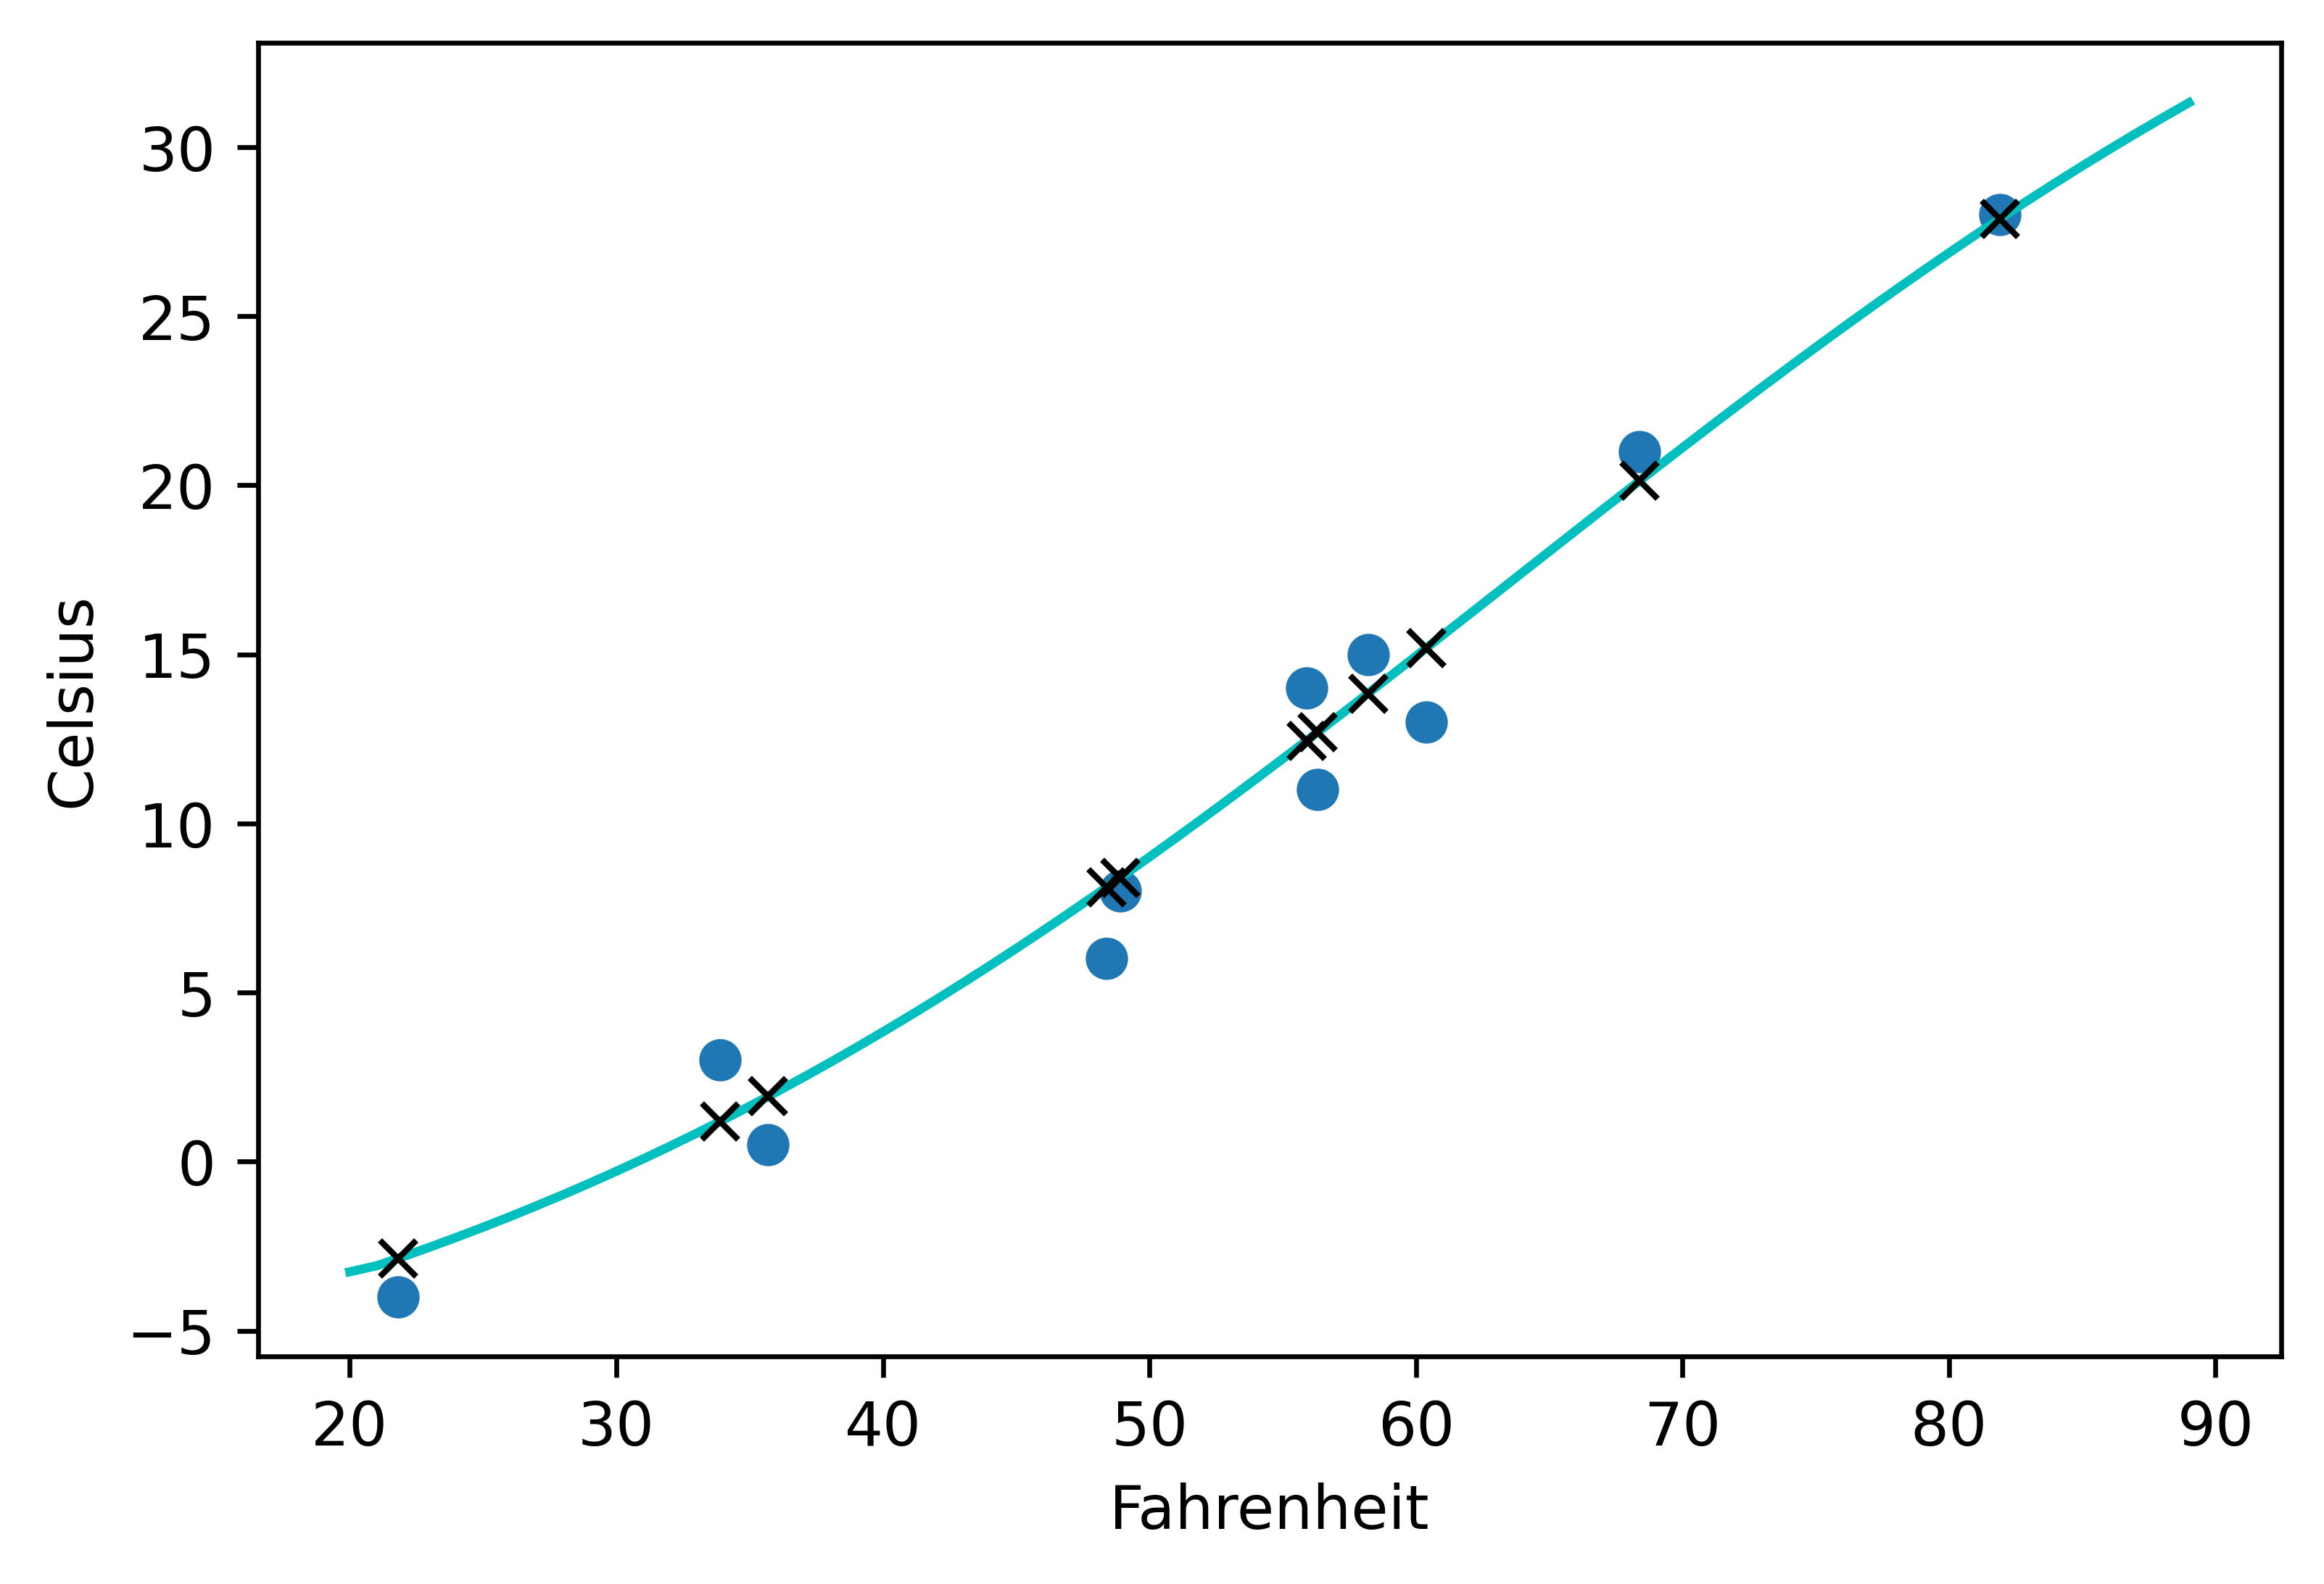

In [ ]:
# 作圖
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1) # x軸範圍從20-90
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
# x軸數據皆為t_u.numpy()
plt.plot(t_u.numpy(), t_c.numpy(), 'o') # 最原始u和c的數據
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') # ?? 應該是沿著x畫線 c藍綠色 -為線
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx') # 訓練後的數據 k為黑色 x為x標